
--- CSA TCNN TSP (Cheng–Aihara, combined version) ---
Global minima : 7 (0.14%)
Local minima  : 4993 (99.86%)


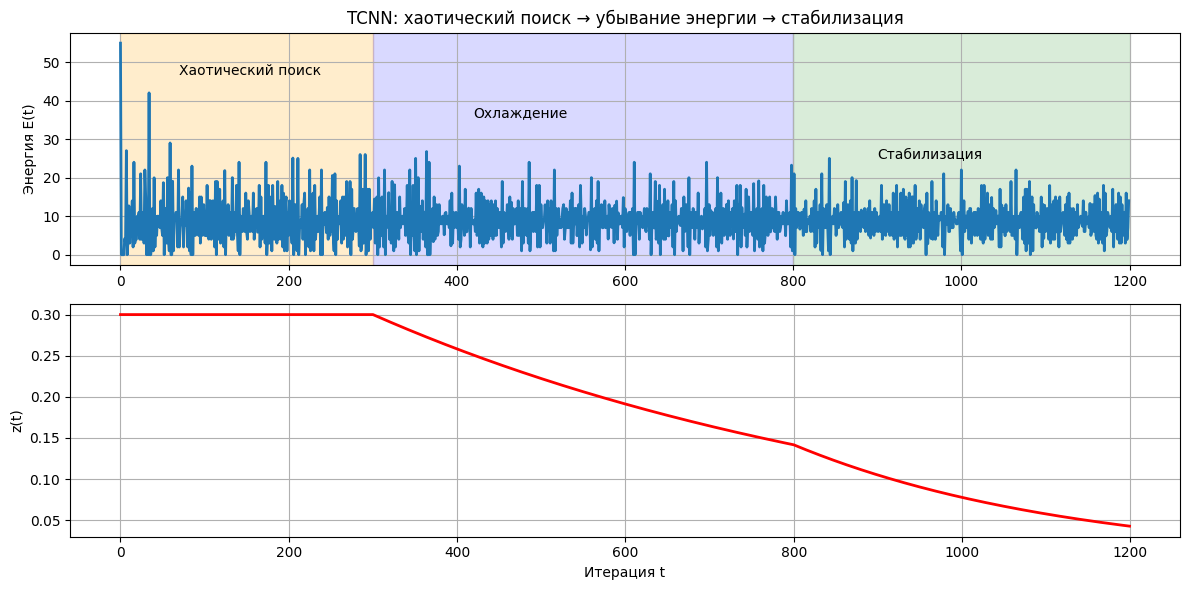

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# ============================================================
# TSP DATA (Cheng–Aihara, 10 cities)
# ============================================================

coords = np.array([
    [0.41, 0.43],
    [0.18, 0.22],
    [0.82, 0.67],
    [0.66, 0.41],
    [0.55, 0.85],
    [0.27, 0.63],
    [0.73, 0.29],
    [0.58, 0.69],
    [0.86, 0.55],
    [0.32, 0.26],
])

n = len(coords)
D = np.linalg.norm(coords[:, None] - coords[None, :], axis=2)

OPTIMAL = 2.70  # глобальный минимум из статьи

# ============================================================
# NUMERICALLY STABLE SIGMOID
# ============================================================

def sigmoid(u):
    return 1.0 / (1.0 + np.exp(-np.clip(u, -20, 20)))

# ============================================================
# CHAOTIC MAP (AUXILIARY, CSA)
# ============================================================

def chaotic_step(xi, a=3.8):
    return a * xi * (1 - xi)

# ============================================================
# TCNN STEP (Cheng–Aihara + CSA)
# ============================================================

def tcnn_step(y, z, xi):
    c = 1 / 250
    I0 = 0.65
    W1 = 1.5
    W2 = 1.0

    x = sigmoid(y / c)

    # --- permutation constraints ---
    row = np.sum(x, axis=1, keepdims=True)
    col = np.sum(x, axis=0, keepdims=True)
    constraint = W1 * ((row - 1) + (col - 1))

    # --- tour length gradient ---
    grad = np.zeros_like(x)
    for j in range(n):
        jp = (j + 1) % n
        jm = (j - 1) % n
        grad[:, j] = D @ (x[:, jp] + x[:, jm])

    # --- CSA noise: only active for large z ---
    noise = 0.12 * z * (xi - 0.5) if z > 0.05 else 0.0

    y = y - constraint - grad - z * (x - I0) + noise
    return y, x

# ============================================================
# ENERGY (DIAGNOSTIC ONLY)
# ============================================================

def energy(x):
    return np.sum(x * x)

# ============================================================
# TOUR LENGTH
# ============================================================

def tour_length(t):
    return sum(D[t[i], t[(i + 1) % n]] for i in range(n))

# ============================================================
# MAIN EXPERIMENT (CSA)
# ============================================================

def run_experiment(trials=5000, steps=1200):
    g = l = 0
    energy_trace = []
    z_trace = []

    for trial in range(trials):
        y = np.random.uniform(-1, 1, (n, n))
        xi = np.random.rand(n, n)

        z = 0.30
        z_min = 0.01
        z_max = 0.30

        E_prev = None
        stagnant = 0

        for t in range(steps):
            xi = chaotic_step(xi)
            y, x = tcnn_step(y, z, xi)
            E = energy(x)

            if trial == 0:
                energy_trace.append(E)
                z_trace.append(z)

            # ===== CSA PHASES =====
            if t < 300:              # chaotic search
                z = z
            elif t < 800:            # cooling
                z = max(z * 0.9985, z_min)
            else:                    # stabilization
                z = max(z * 0.997, z_min)

            # --- adaptive reheating if stuck ---
            if E_prev is not None:
                if abs(E - E_prev) < 1e-6:
                    stagnant += 1
                else:
                    stagnant = 0

            if stagnant > 60 and z < z_max:
                z = min(z * 1.05, z_max)
                stagnant = 0

            E_prev = E

        # ===== PROJECTION (EVALUATION ONLY) =====
        x_proj = np.where(x > 0.5, x, 0.0)
        rows, cols = linear_sum_assignment(-x_proj)
        tour = rows[np.argsort(cols)]
        L = tour_length(tour)

        if abs(L - OPTIMAL) < 1e-3:
            g += 1
        else:
            l += 1

    return g, l, energy_trace, z_trace

# ============================================================
# RUN
# ============================================================

g, l, E, zt = run_experiment()
N = g + l

print("\n--- CSA TCNN TSP (Cheng–Aihara, combined version) ---")
print(f"Global minima : {g} ({100*g/N:.2f}%)")
print(f"Local minima  : {l} ({100*l/N:.2f}%)")

# ============================================================
# PLOTS
# ============================================================

plt.figure(figsize=(12, 6))

# --- ENERGY ---
plt.subplot(2, 1, 1)
plt.plot(E, linewidth=2)
plt.ylabel("Энергия E(t)")
plt.title("TCNN: хаотический поиск → убывание энергии → стабилизация")
plt.grid(True)

plt.axvspan(0, 300, color="orange", alpha=0.2)
plt.axvspan(300, 800, color="blue", alpha=0.15)
plt.axvspan(800, 1200, color="green", alpha=0.15)

plt.text(70, max(E)*0.85, "Хаотический поиск")
plt.text(420, max(E)*0.65, "Охлаждение")
plt.text(900, max(E)*0.45, "Стабилизация")

# --- z(t) ---
plt.subplot(2, 1, 2)
plt.plot(zt, color="red", linewidth=2)
plt.xlabel("Итерация t")
plt.ylabel("z(t)")
plt.grid(True)

plt.tight_layout()
plt.show()
